In [32]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#### Data preprocessing

In [33]:
# Reading in LA County case and death data
# Dates 1/26/2020 through 2/22/2022 for this iteration
la = pd.read_csv('https://raw.githubusercontent.com/nmonozon/modeling-covid-19/main/Datasets/covid-19-los-angeles-county.csv', index_col='date')[0:759]

In [34]:
la.tail()

,day,county,state,fips,cases,deaths
date,,,,,,
2022-02-18,755,Los Angeles,California,6037.0,2777869,30216.0
2022-02-19,756,Los Angeles,California,6037.0,2781027,30300.0
2022-02-20,757,Los Angeles,California,6037.0,2783657,30356.0
2022-02-21,758,Los Angeles,California,6037.0,2784980,30376.0
2022-02-22,759,Los Angeles,California,6037.0,2786153,30411.0


In [35]:
# Column for new cases per day
la['new_cases'] = 0 
for i in range(1,len(la)):
    la['new_cases'].iloc[i] = la['cases'].iloc[i] - la['cases'].iloc[i-1]

C:\Users\Nicolas\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [36]:
la['week'] = la['day'] // 7
weekly_la = la.groupby('week')[['new_cases']].sum()
weekly_la['one_week_before'] = weekly_la['new_cases'].shift(1)
weekly_la['change'] = weekly_la['new_cases'].shift(1) - weekly_la['new_cases'].shift(2)
weekly_la.dropna(inplace = True)
weekly_la = weekly_la.iloc[1::]

In [37]:
weekly_la

,new_cases,one_week_before,change
week,,,
3,0,0.0,0.0
4,0,0.0,0.0
5,12,0.0,0.0
6,27,12.0,12.0
7,252,27.0,15.0
...,...,...,...
104,181641,256736.0,-27746.0
105,99977,181641.0,-75095.0
106,42036,99977.0,-81664.0


#### ARIMA model

In [38]:
# ARIMA Model 
from pmdarima import auto_arima
stepwise_fit = auto_arima(weekly_la['new_cases'], trace = True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=2323.693, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2589.054, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2407.557, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2513.781, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2615.062, Time=0.00 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=2330.720, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=2335.632, Time=0.02 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=2325.537, Time=0.05 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=2326.056, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2366.411, Time=0.02 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=2327.295, Time=0.03 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=2338.251, Time=0.05 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=2327.390, Time=0.06 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=2325.575, Time=0.02 sec

Best model:  ARIMA(2,0,2)(0,0,0)

In [39]:
import statsmodels.api as sm
model = sm.tsa.arima.ARIMA(weekly_la['new_cases'], order = (2,0,2))
model = model.fit()
model.summary()

C:\Users\Nicolas\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\Nicolas\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\Nicolas\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              new_cases   No. Observations:                  106
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -1155.606
Date:                Tue, 01 Mar 2022   AIC                           2323.213
Time:                        23:37:12   BIC                           2339.194
Sample:                             0   HQIC                          2329.690
                                - 106                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.628e+04   1.73e+04      1.521      0.128   -7578.352    6.01e+04
ar.L1          1.1936      0.173      6.910      0.000       0.855       1.532
ar.L2         -0.4231      0.180     -2.357      0.018      -0.775      -0.071
ma.L1          0.4443      0.162      2.749      0.006       0.128       0.761
ma.L2          0.5312      0.167      3.176      0.001       0.203       0.859
sigma2      1.802e+08     19.591    9.2e+06      0.000     1.8e+08     1.8e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               456.14
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):              26.29   Skew:                             1.55
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.75e+21. Standard errors may be unstable.
"""

In [40]:
preds = model.predict()

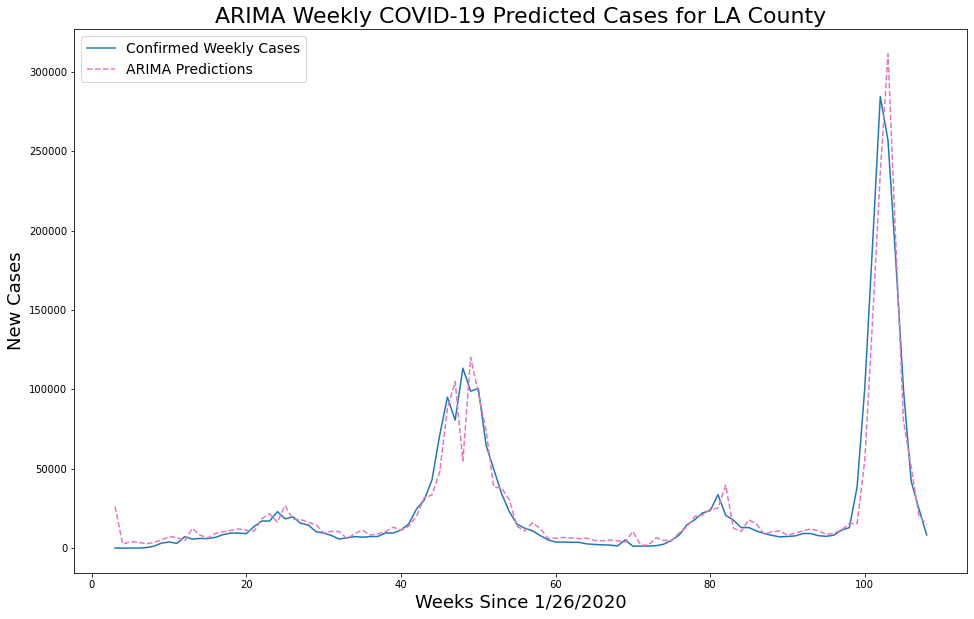

In [41]:
plt.figure(figsize = (16,10))
plt.plot(weekly_la['new_cases'], label = 'Confirmed Weekly Cases')
plt.plot(model.predict(), label = 'ARIMA Predictions', color='tab:pink', linestyle='dashed')
plt.xlabel('Weeks Since 1/26/2020', fontsize=18)
plt.ylabel('New Cases', fontsize=18)
plt.title('ARIMA Weekly COVID-19 Predicted Cases for LA County', fontsize=22)
plt.legend(prop={'size': 14})
# plt.savefig("arima.png")
# files.download("arima.png") 

In [42]:
# Week
week = 108

In [43]:
# MAE and MSE
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
print('MAE:', mean_absolute_error(weekly_la['new_cases'], preds))
print('MSE:', mean_squared_error(weekly_la['new_cases'], preds))

MAE: 6756.3068020718965
MSE: 171932700.93029645


In [44]:
from sklearn.metrics import r2_score
print('R^2:', r2_score(weekly_la['new_cases'], preds))

R^2: 0.9247406322023894


In [46]:
# Actual data from Week 108
week_actual = weekly_la.loc[week]
week_actual

new_cases           8284.0
one_week_before    24767.0
change            -17269.0
Name: 108, dtype: float64

In [45]:
# Predictions
model.predict(start = week, end = week + 2)

C:\Users\Nicolas\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


108     9702.589881
109    15590.093094
110    20535.687035
Name: predicted_mean, dtype: float64